# 🧠 Store Sales Forecasting using LSTM
This notebook uses LSTM (Long Short-Term Memory) neural networks to forecast daily store sales based on historical data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Load dataset
traindata = pd.read_csv('/content/train 2.csv')
traindata['date'] = pd.to_datetime(traindata['date'])
traindata = traindata.sort_values('date')
traindata.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1194,1194,2013-01-01,42,CELEBRATION,0.0,0
1193,1193,2013-01-01,42,BREAD/BAKERY,0.0,0
1192,1192,2013-01-01,42,BOOKS,0.0,0
1191,1191,2013-01-01,42,BEVERAGES,0.0,0


In [ ]:
# Aggregate sales data
daily_sales = traindata.groupby('date')['sales'].sum().reset_index()
daily_sales.head()


,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


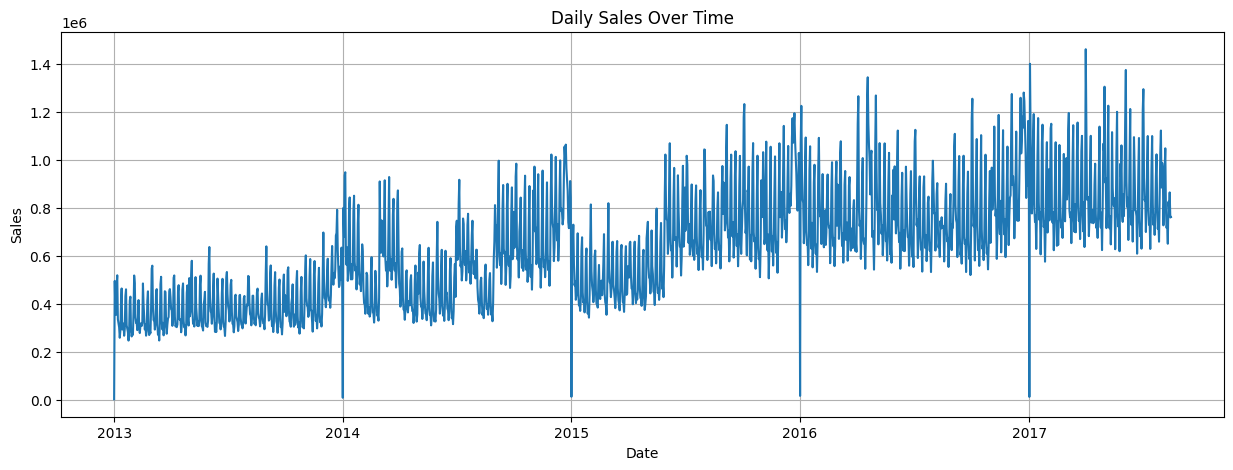

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.show()


In [ ]:
# Normalize sales
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(daily_sales[['sales']])

# Create sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_sales, window_size)

# Train/validation split
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(window_size, 1)))
# model.add(LSTM(16, activation='relu', ))
#
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val))


Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1317 - val_loss: 0.1063
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0309 - val_loss: 0.0172
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0104 - val_loss: 0.0187
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0102 - val_loss: 0.0169
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0097 - val_loss: 0.0169
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0103 - val_loss: 0.0168
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0096 - val_loss: 0.0167
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0104 - val_loss: 0.0167
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0104 - val_loss: 0.0171
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0103 - val_loss: 0.0166
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0097 - val_loss: 0.0167
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 

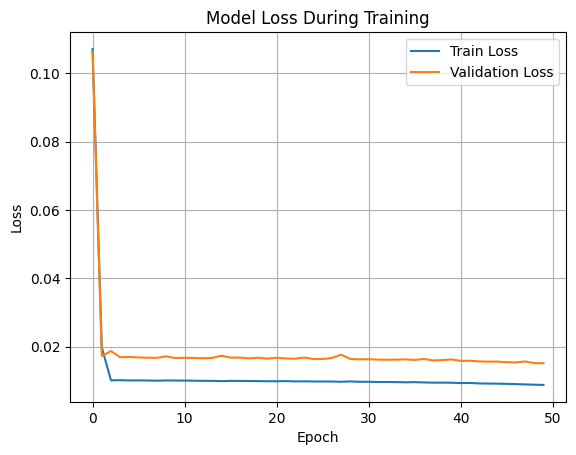

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [ ]:
y_pred = model.predict(X_val)
y_pred_inv = scaler.inverse_transform(y_pred)
y_val_inv = scaler.inverse_transform(y_val)

mse = mean_squared_error(y_val_inv, y_pred_inv)
mae = mean_absolute_error(y_val_inv, y_pred_inv)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Squared Error: 32235446686.02
Mean Absolute Error: 142038.31


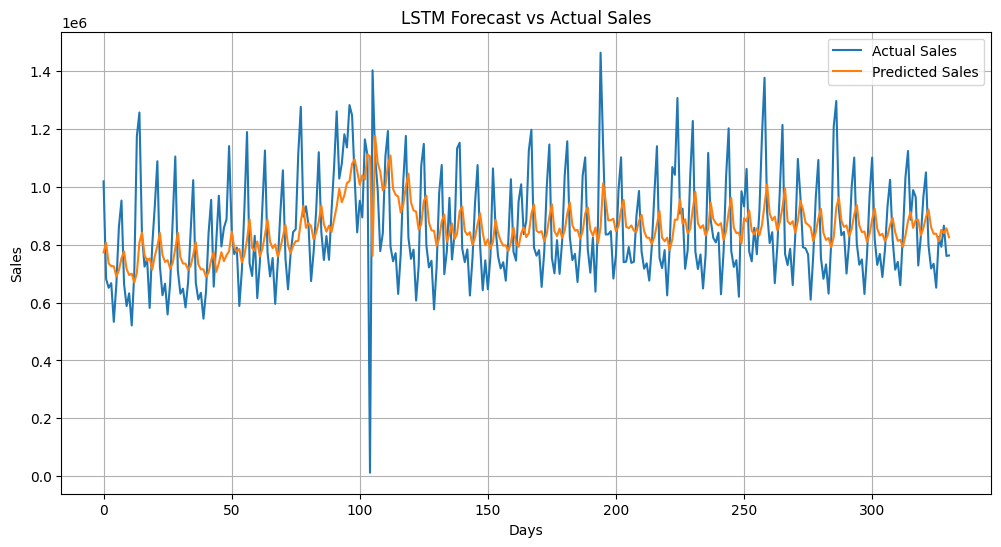

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_val_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.title("LSTM Forecast vs Actual Sales")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


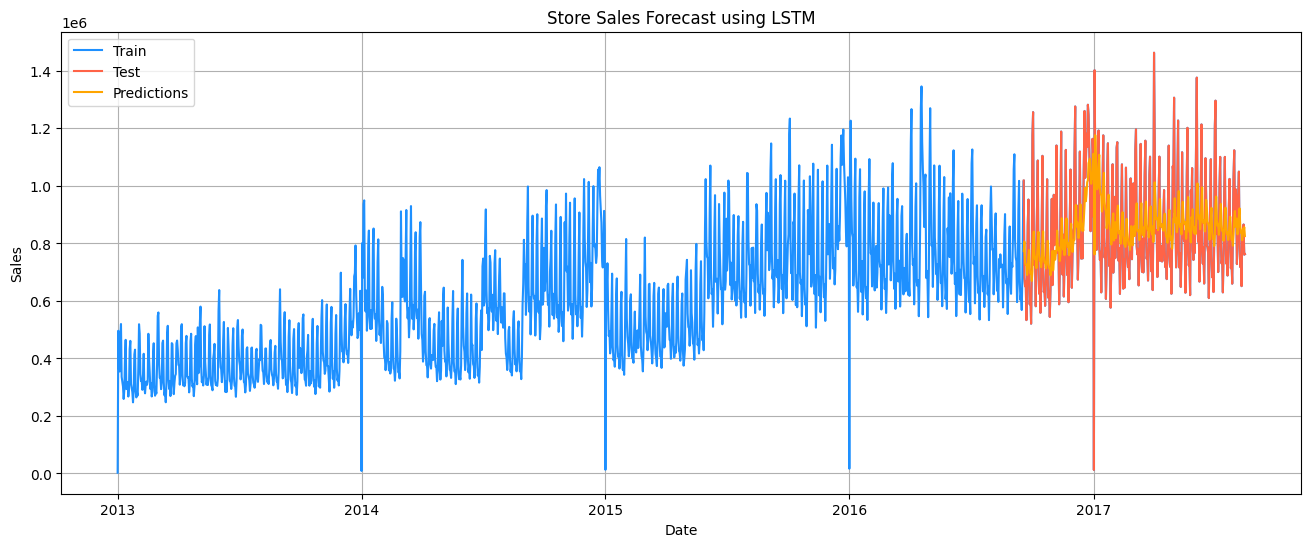

In [ ]:
# Prepare full data for plotting
full_data = np.concatenate((scaler.inverse_transform(scaled_sales), [[None]] * window_size))
predicted_full = [None] * (len(full_data) - len(y_pred_inv)) + list(y_pred_inv.flatten())

plt.figure(figsize=(16,6))
plt.plot(daily_sales['date'], full_data[:-window_size], label='Train', color='dodgerblue')
plt.plot(daily_sales['date'][-len(y_val_inv):], y_val_inv.flatten(), label='Test', color='tomato')
plt.plot(daily_sales['date'][-len(y_pred_inv):], y_pred_inv.flatten(), label='Predictions', color='orange')
plt.title("Store Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

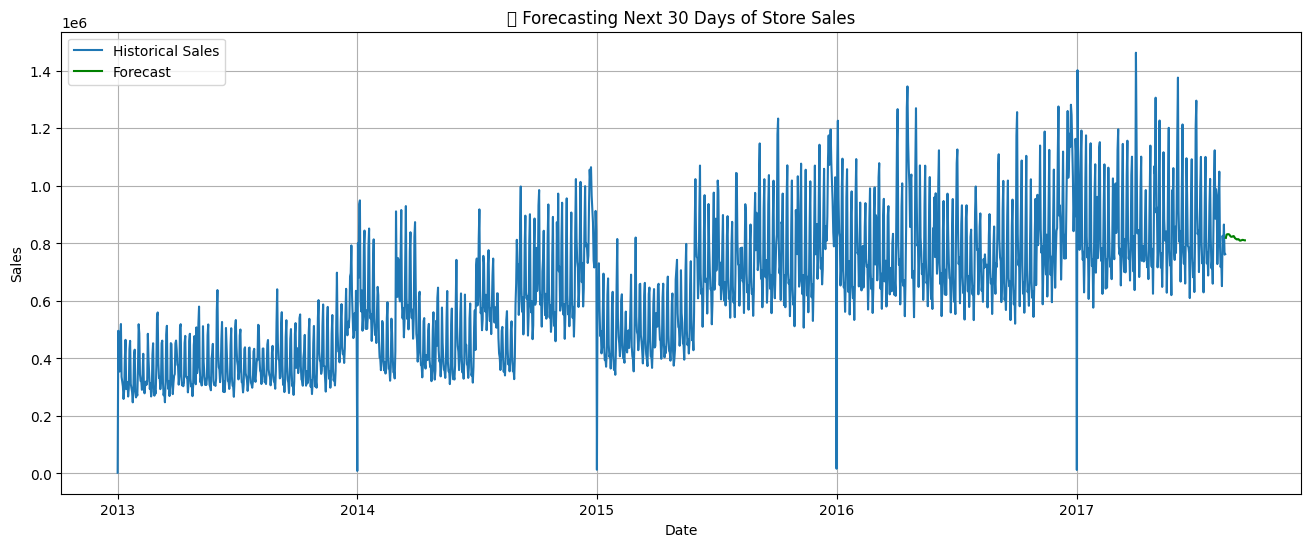

In [ ]:
# Number of days to forecast
forecast_days = 30

# Start with the last window from the full scaled sales data
input_seq = scaled_sales[-window_size:].reshape(1, window_size, 1)

forecast = []

for _ in range(forecast_days):
    pred = model.predict(input_seq)[0][0]
    forecast.append(pred)

    # Update the input sequence
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

# Inverse scale to get actual sales
forecast_inv = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create future date range
last_date = daily_sales['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

# Plot actual + forecast
plt.figure(figsize=(16, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Historical Sales')
plt.plot(future_dates, forecast_inv, label='Forecast', color='green')
plt.title("📈 Forecasting Next 30 Days of Store Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('model.keras')